In [1]:
import hopsy
# hopsy will work with the python interface of glpk but it is strongly recommended to install gurobipy with a free academic license

import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp # for fixing mean

In [2]:
class Param:
    '''
    Helper utility class
    '''
    def __init__(self, model_dir, stepsize):
            self.model_dir = model_dir
            self.stepsize = stepsize
            self.n_samples = 2500
            self.n_thinning = 5
        
        
    def __repr__(self):
        return self.model_dir 

In [3]:
def check_and_fix_start_point(mean, 
                              cov,
                              inequality_matrix,
                              inequality_rhs,
                              epsilon=1e-3):
    
    '''
    For cases where the mean violates the constraints, the starting point of the polytope should be 
    set to a point which is close to the mean in euklid distance, but which does not violate the constraints.
    epsilon controlls how close to the constraints the fixed point can be.

    epsilon: should always be positive
    '''

    slacks = np.min(inequality_rhs - inequality_matrix.dot(mean))
    if slacks <= epsilon:
        # we have to fix mean using qp
        fixed_mean = cp.Variable(mean.shape[0])
        # use the covariance as metric for distance
        R = np.linalg.cholesky(cov)
        objective = cp.Minimize(cp.sum_squares(R@fixed_mean - mean))

        epsilon_vector = epsilon*np.ones(inequality_rhs.shape[0])
        constraints = [inequality_matrix @ fixed_mean <= inequality_rhs.flatten() - epsilon_vector]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        fixed_slacks = np.min(inequality_rhs - inequality_matrix.dot(fixed_mean.value))
        if(fixed_slacks*10 <= epsilon):
            print(fixed_slacks)
            raise RuntimeError("could not fix mean with quadratic programming")
        return fixed_mean.value
    else:
        return mean

In [4]:
def run_sampling(n_samples: int,
              n_thinning:int,
              mean: np.array,
              cov: np.array,
              inequality_matrix: np.array,
              inequality_rhs: np.array,
              lower_bounds: float,
              upper_bounds: float,
              stepsize: float = 1.,
              n_chains=4):
    
    model = hopsy.Gaussian(mean, cov)
    
    problem = hopsy.add_box_constraints(hopsy.Problem(inequality_matrix, inequality_rhs, model), lower_bounds, upper_bounds)
    
    #proposal_type = hopsy.CSmMALAProposal
    proposal_type = hopsy.BilliardMALAProposal
    
    mean = check_and_fix_start_point(mean, cov, inequality_matrix, inequality_rhs)
    markov_chains = [
        hopsy.MarkovChain(problem, proposal_type, starting_point=mean) for i in range(n_chains)
    ]
    
    for mc in markov_chains:
        mc.proposal.stepsize = stepsize
    
    # one random number generator is required for every chain. technically you should make sure, that all rngs have different seeds.
    rng = [ hopsy.RandomNumberGenerator(random.randint(1, 250000)) for i in range(n_chains) ]
    
    start = time.time()
    acceptance_rates, samples = hopsy.sample(markov_chains,rng, n_samples, thinning=n_thinning, n_threads=n_chains)
    end = time.time()
    
    print('runtime: ' + str(int(100*(end-start)) / 100) + " seconds")
    
    # rhat < 1.1 indicates convergence of samples
    print('rhat:' + str(np.max(hopsy.rhat(samples))))
    # acceptance rate close to 0 or 1 are problematic for efficiency
    print('acceptance rate:' + str(acceptance_rates))
    return acceptance_rates, samples, end-start

In [5]:
def run_hopsy(param: Param):      
    inequality_matrix_path = os.path.join(param.model_dir, "InequalityConstraintMatrix.csv")
    inequality_matrix = pd.read_csv(inequality_matrix_path, index_col=0).values
    inequality_rhs_path = os.path.join(param.model_dir, "InequalityConstraintRighthandSide.csv")
    inequality_rhs = pd.read_csv(inequality_rhs_path, index_col=0).values.flatten()
    mean_path = os.path.join(param.model_dir, 'MeanVector.csv')
    mean = pd.read_csv(mean_path, index_col=0).values.flatten()
    
    cov_path = os.path.join(param.model_dir, 'CovarianceMatrix.csv')
    cov = pd.read_csv(cov_path, index_col=0).values
        
    print(param)
    return run_sampling(
        param.n_samples,
        param.n_thinning,
        mean,
        cov,
        inequality_matrix,
        inequality_rhs,
        lower_bounds=-1000,
        upper_bounds=1000,
        stepsize=param.stepsize
    )

In [6]:
model_dirs = [
    'ecoli_noor_2016_glycolysis_kinetic_posterior_matrices',
    #'hynne_example_posterior_matrices',
    #'pb_ecoli_noor_2016_glycolysis_metabolic_posterior_matrices',
    #'pb_ecoli_noor_2016_glycolysis_posterior_matrices',
    # the next two models take quite some time to sample and also requires more samples
    # 'pb_ecoli_noor_2016_metabolic_posterior_matrices', 
    # 'pb_ecoli_noor_2016_posterior_matrices'
] 

stepsizes = [
    1,
    1,
    1,
    1,
    # guessed step sizes for the harder models
    # 0.3, 
    # 0.3
]

params = []

for i, m in enumerate(model_dirs):
    params.append(
        Param(m, stepsizes[i])
    )
                
if __name__ == "__main__":
    result = {}
    for param in params:
        result[param.model_dir] = {}
        acceptance_rates, samples, runtime = run_hopsy(param)
        result[param.model_dir]['acceptance_rates'] = acceptance_rates
        result[param.model_dir]['samples'] = samples
        result[param.model_dir]['runtime'] = runtime

ecoli_noor_2016_glycolysis_kinetic_posterior_matrices
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
runtime: 18.02 seconds
rhat:1.0331685385589857
acceptance rate:[0.72032, 0.7157600000000001, 0.71368, 0.71824]


In [10]:
result["ecoli_noor_2016_glycolysis_kinetic_posterior_matrices"]["samples"].shape

(4, 2500, 68)

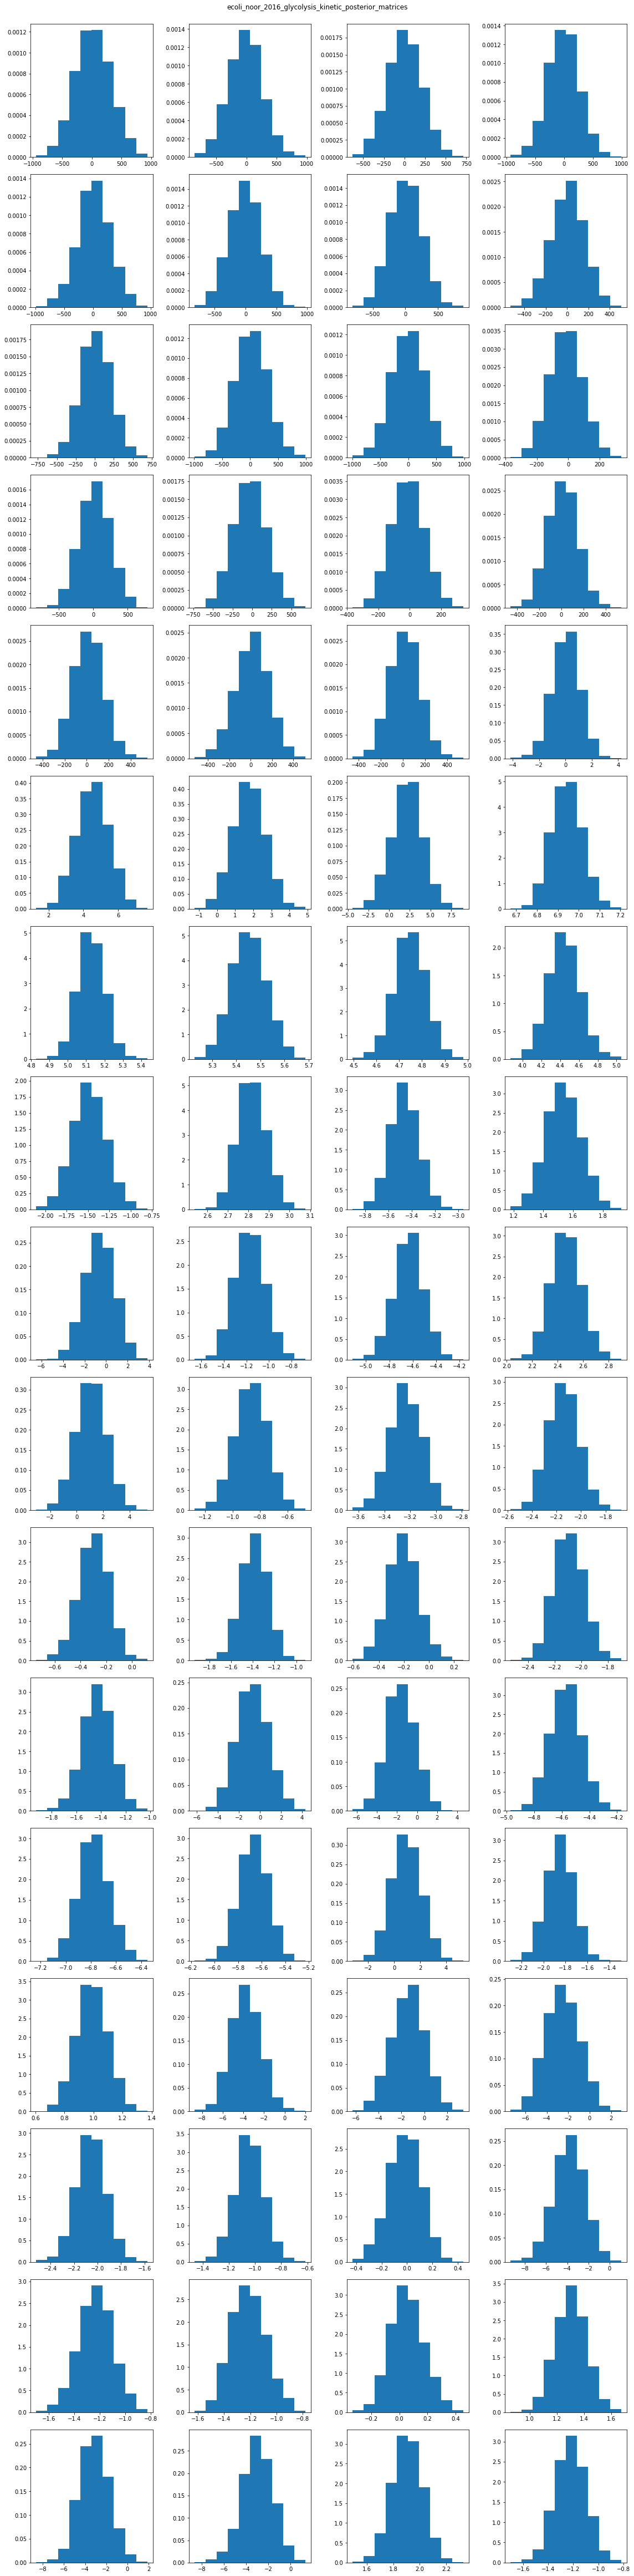

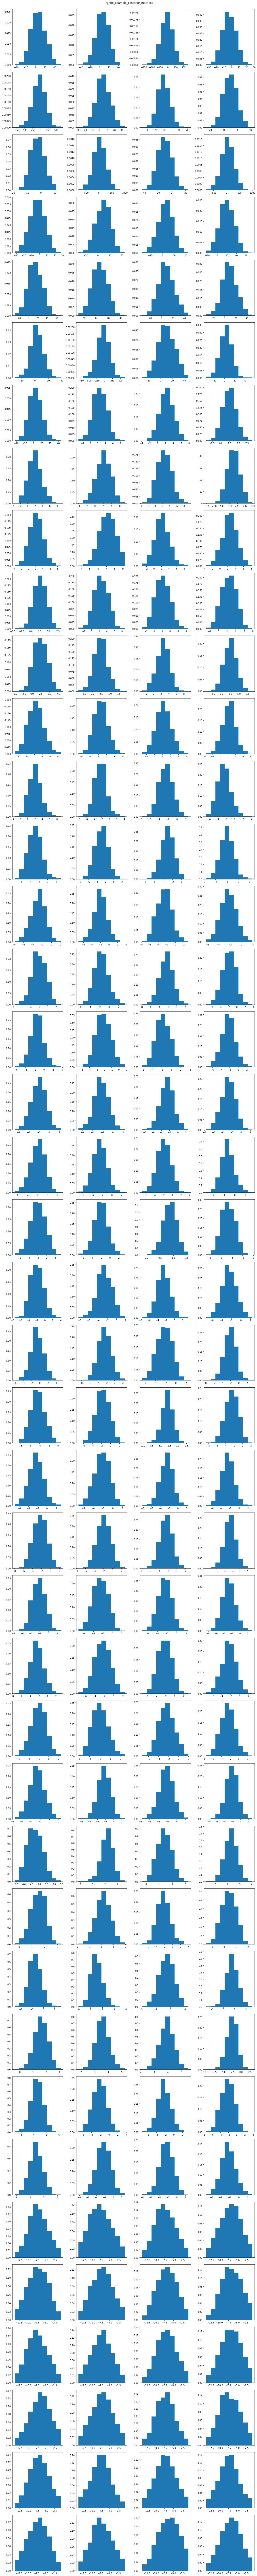

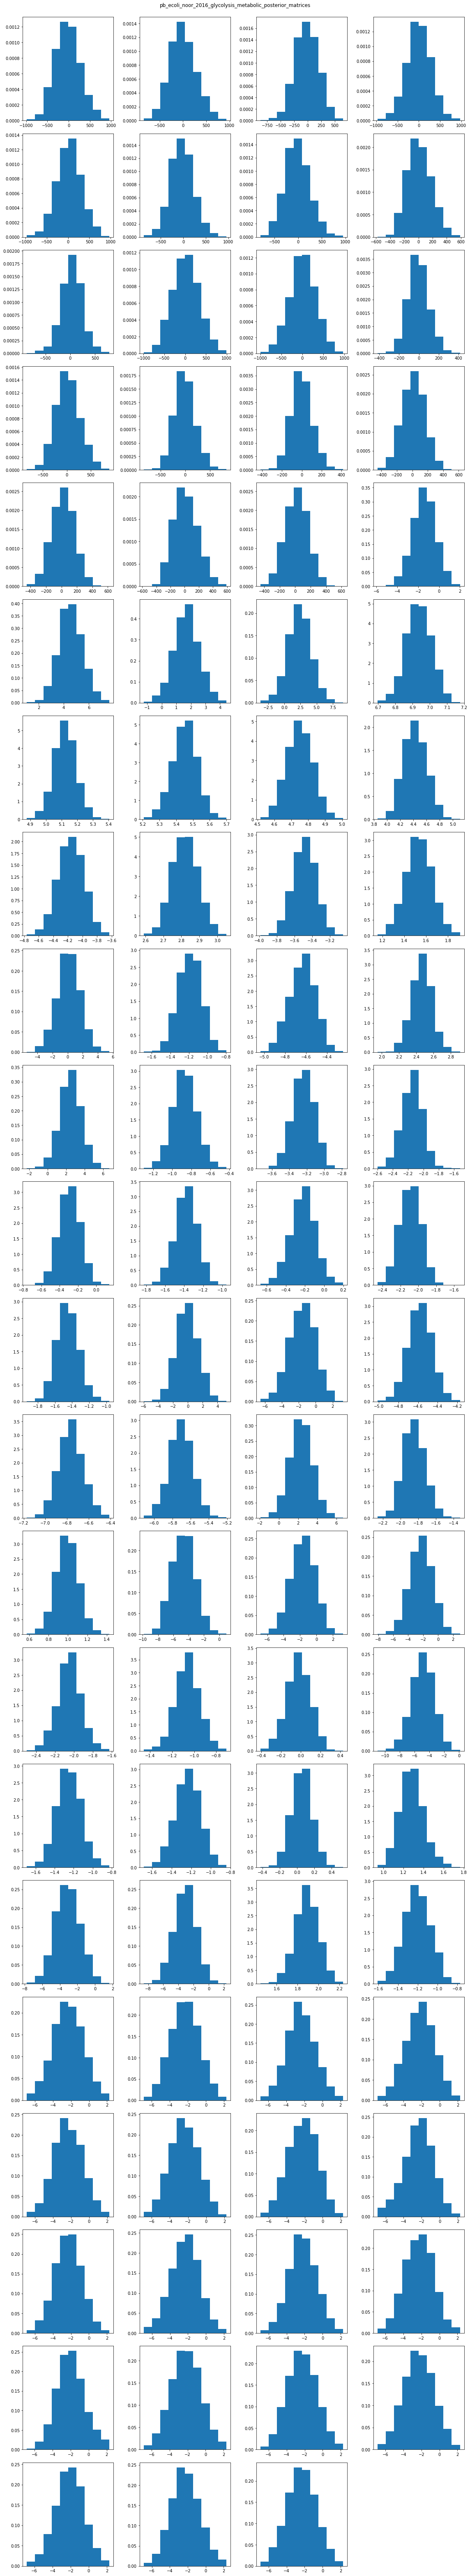

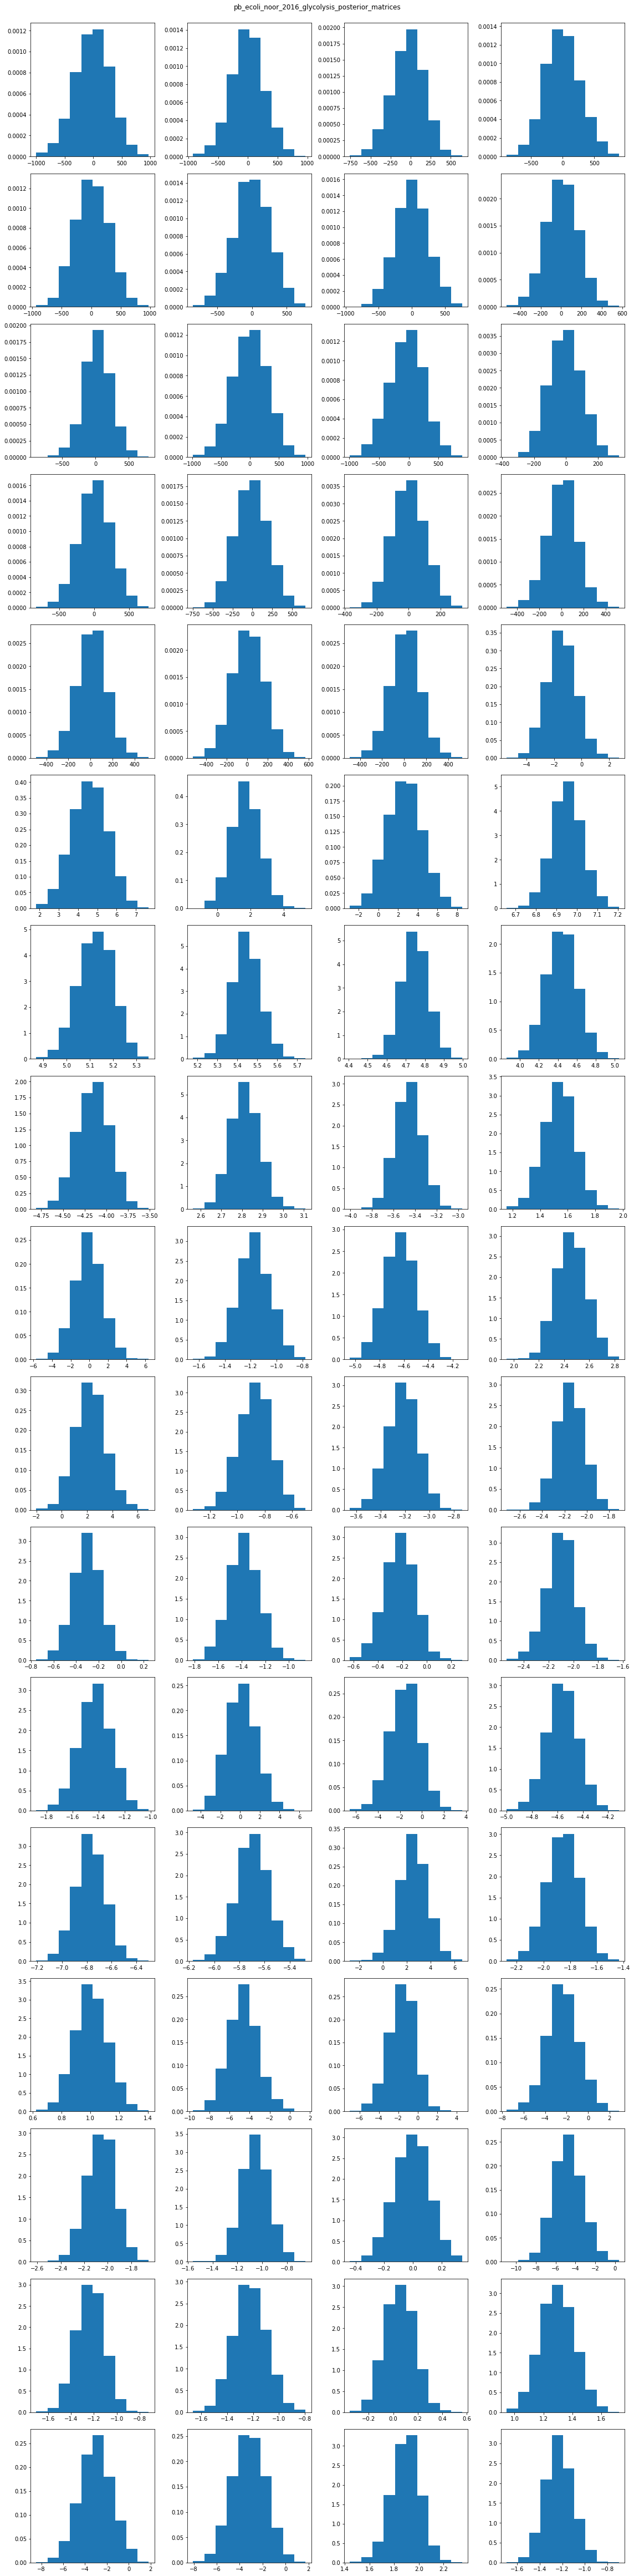

In [15]:
for k, v in result.items():
    plt.figure(figsize=(16, v['samples'].shape[2]))
    plt.suptitle(k, y=1 )
    for i in range(v['samples'].shape[2]):
        samples = v['samples'][:,:,i].flatten() # merges all samples of one parameter into single array
        plt.subplot(int(v['samples'].shape[2]/4) + 1, 4, i+1)
        plt.hist(samples, density=True)
    plt.tight_layout()
    plt.show()